## Dynamic models in interface design

This Notebook will explore the use of dynamic models in interface design.

Let us start off by looking at the vector fields associated with a simple linear system
$$\dot{x}=Ax+Bu$$

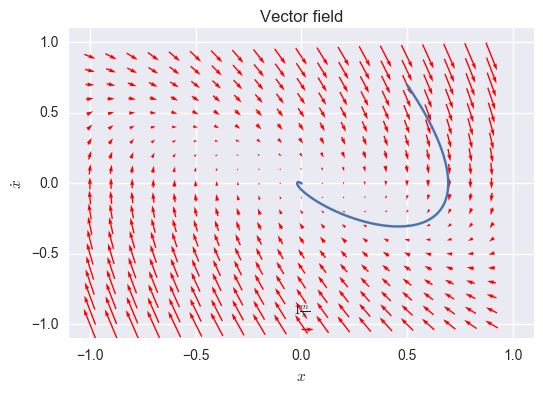

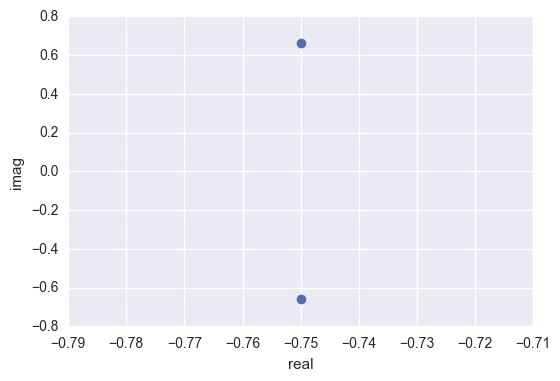

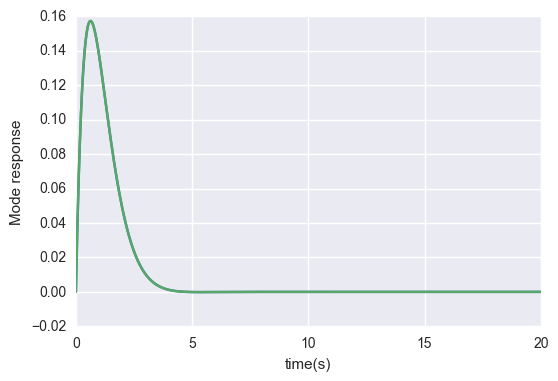

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from pylab import *
import seaborn as sns
# Enable inline plotting
%matplotlib inline

#A = [[1., -2], [3, -4]]
#A = [[-2 , -3], [3, -2]]
M = 1   # mass in kg
d = 1.5 # damping coeff Ns/m
K=1     # spring ceoff N/m
# Dynamics matrix
A = [[0 , 1], [-K/M, -d/M]]
B = [[0], [1]]

X,Y = meshgrid( arange(-1,1,.1),arange(-1,1,.1) )
XX = vstack((reshape(X,len(X)**2,order='C'), reshape(Y,len(X)**2,order='C')))
UU = np.dot(A,XX)
U = reshape(UU[0,],(len(X),len(X)),order='C')
V = reshape(UU[1,],(len(X),len(X)),order='C')


Q = quiver(X,Y,U, V,pivot='mid', color='r', units='inches' )
qk = quiverkey(Q, 0.5, 0.03, 1, r'$1 \frac{m}{s}$', fontproperties={'weight': 'bold'});
#qk = quiverkey( Q, 0.5, 0.92, 2, r'$2 \frac{m}{s}$', labelpos='W', fontproperties={'weight': 'bold'});
l,r,b,t = axis()
dx, dy = r-l, t-b
axis([l-0.05*dx, r+0.05*dx, b-0.05*dy, t+0.05*dy])

title('Vector field')
plt.xlabel('$x$');
plt.ylabel('$\dot{x}$')
 
import scipy as sp
def testSyst(state, t, A):
  xdot = dot(A,state)
  return [xdot[0], xdot[1]]

x0 = [0.5, 0.7]

t = arange(0.0, 20.0, 0.001)
state = sp.integrate.odeint(testSyst, x0, t, args = (A,))
plt.plot(state[:,0],state[:,1]);

plt.figure()
w, v = np.linalg.eig(A)
plt.plot(real(w),imag(w),'o');
plt.xlabel('real');
plt.ylabel('imag');

# let's look at the time-series responses associated with the poles (eigenvalues)
plt.figure();
for i in w:
    if isreal(i):
        plt.plot(t,exp(-2*i));
    else:
        plt.plot(t,np.exp(2*real(i)*t)*sin(t*np.abs(imag(i))));
plt.xlabel('time(s)');
plt.ylabel('Mode response');
        

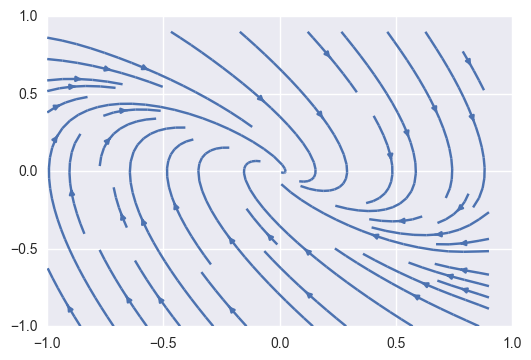

In [3]:
streamplot(X, Y, U, V, density=[0.5, 1]);

Let us simulate a simple spring-mass-damper system, where 
$$
A = \left[\begin{smallmatrix}0 & 1\\-\frac{K}{M}& -\frac{d}{M}\end{smallmatrix}\right]
$$

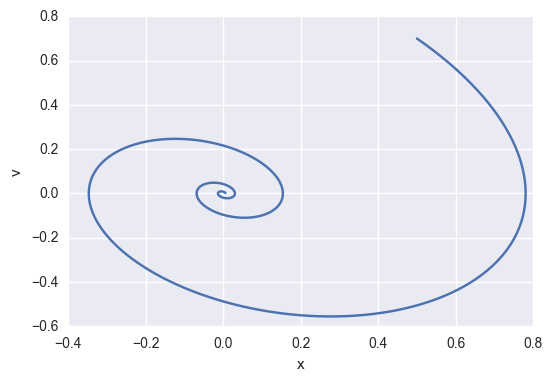

In [4]:
M = 1 # mass in kg
d = 0.5 # damping coeff Ns/m
K=1 # spring ceoff N/m
# Dynamics matrix
A = [[0 , 1], [-K/M, -d/M]]

# simulation using a simple ODE integration routine
state = sp.integrate.odeint(testSyst, x0, t, args = (A,))
plt.plot(state[:,0],state[:,1]);
plt.xlabel('x');
plt.ylabel('v');


If you want to simulate a system with mass and friction you can set $K=0$, but if you want to give it a resting point it will balance around, you can set $K>0$. Could we use this to create a series of attractors?

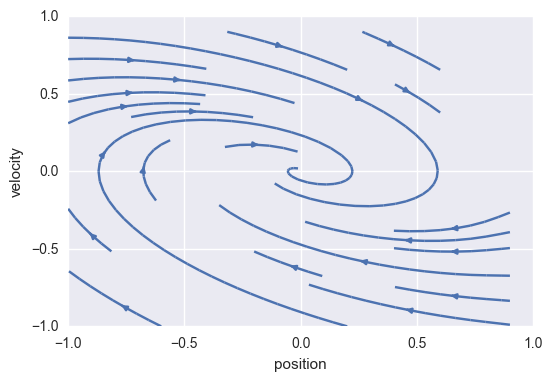

In [8]:
K=0.4 #play around with this value and look at the effect on the dynamics
A = [[0 , 1], [-K/M, -d/M]]
UU = np.dot(A,XX)
U = reshape(UU[0,],(len(X),len(X)),order='C')
V = reshape(UU[1,],(len(X),len(X)),order='C')
streamplot(X, Y, U, V, density=[0.2, 1]);
plt.xlabel('position');
plt.ylabel('velocity');

You can see that the trajectories converge on zero velocity (the system slows to a stop) at a range of positions, depending on the initial conditions.


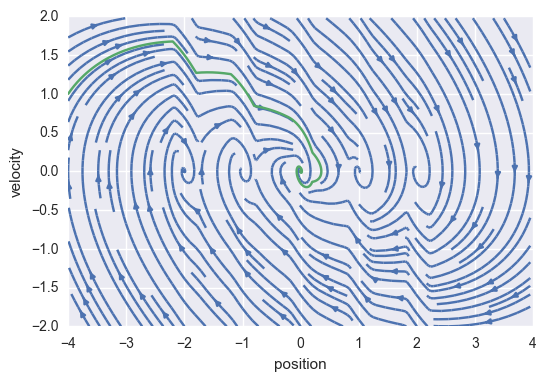

In [9]:
def multiTarget(state, t, A, Atarg, targpos):

  minp= np.argmin(np.abs(targpos-np.ones(shape(targpos))*state[0]))
  # switch dynamic behaviour to Atarg when close to a target 
  if np.abs(targpos[minp]-state[0])<0.2:
    thisstate = [state[0]-targpos[minp], state[1]]
    xdot = dot(Atarg,thisstate)
  else:
    xdot = dot(A,state)
    
  return [xdot[0], xdot[1]]

targpos = [2, 1, 0, -1, -2];
Ktarg = 2
dtarg = 2*d
x0= [-4,1]
Atarg = [[0 , 1], [-Ktarg/M, -dtarg/M]]

X,Y = meshgrid( arange(-4,4,.05),arange(-2,2,.025) )
XX = vstack((reshape(X,len(X)**2,order='C'), reshape(Y,len(X)**2,order='C')))
UU = np.zeros((2,len(X)**2))
for i in range(0,(len(X)**2)-1):
    UU[:,i] = multiTarget(XX[:,i], 0, A, Atarg, targpos)
U = reshape(UU[0,],(len(X),len(X)),order='C')
V = reshape(UU[1,],(len(X),len(X)),order='C')
streamplot(X, Y, U, V, density=[1.5, 1.5]);
plt.xlabel('position');
plt.ylabel('velocity');


state = sp.integrate.odeint(multiTarget, x0, t, args = (A, Atarg,targpos))
plt.plot(state[:,0],state[:,1]);

Now try with a surge like model which does not extend infintely in v, we can create a model which does not affect trajectories passing a target at speed.


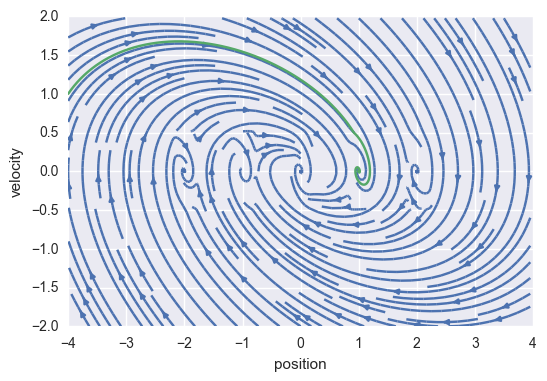

In [10]:
def multiTarget(state, t, A, Atarg, targpos):

  minp= np.argmin(np.abs(targpos-np.ones(shape(targpos))*state[0]))

  # switch dynamic behaviour to Atarg when close to a target 
  if np.abs(targpos[minp]-state[0])<0.2 and np.abs(state[1])<0.5:
    thisstate = [state[0]-targpos[minp], state[1]]
    xdot = dot(Atarg,thisstate)
  else:
    xdot = dot(A,state)
    
  return [xdot[0], xdot[1]]

targpos = [2, 1, 0, -1, -2];
Ktarg = 2
dtarg = 2*d
x0= [-4,1]
Atarg = [[0 , 1], [-Ktarg/M, -dtarg/M]]

X,Y = meshgrid( arange(-4,4,.05),arange(-2,2,.025) )
XX = vstack((reshape(X,len(X)**2,order='C'), reshape(Y,len(X)**2,order='C')))
UU = np.zeros((2,len(X)**2))
for i in range(0,(len(X)**2)-1):
    UU[:,i] = multiTarget(XX[:,i], 0, A, Atarg, targpos)
U = reshape(UU[0,],(len(X),len(X)),order='C')
V = reshape(UU[1,],(len(X),len(X)),order='C')
streamplot(X, Y, U, V, density=[1.5, 1.5]);
plt.xlabel('position');
plt.ylabel('velocity');


state = sp.integrate.odeint(multiTarget, x0, t, args = (A, Atarg,targpos))
plt.plot(state[:,0],state[:,1]);

1D photo browser, test movements when people move to an image without any dynamics.


In [11]:
%cd photo_browser
%run photo_browser.py

/Users/rodmurraysmith/SummerSchool2017/ComputationalInteraction17/Rod/Labs/photo_browser
Will search for images in: "photos"
> Loading: photos/IMG_4231.JPG
> Loading: photos/IMG_4333.JPG
> Loading: photos/IMG_4336.JPG
> Loading: photos/IMG_4354.JPG
> Loading: photos/IMG_4384.JPG
> Loading: photos/IMG_4406.JPG
> Loading: photos/IMG_4456.JPG
> Loading: photos/IMG_4484.JPG
> Loading: photos/IMG_4531.JPG
> Loading: photos/IMG_4636.JPG
> Loading: photos/IMG_4692.JPG
> Loading: photos/IMG_4830.JPG
> Loading: photos/IMG_4836.JPG
> Loading: photos/IMG_4839.JPG
> Loading: photos/IMG_4841.JPG
> Loading: photos/IMG_4884.JPG
> Loading: photos/IMG_5047.JPG
> Loading: photos/IMG_5173.JPG
> Loading: photos/IMG_5194.JPG
> Loading: photos/IMG_5217.JPG
> Loading: photos/IMG_5230.JPG
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input
no input

We can make concrete changes to system dynamics by introduction of control modes. Let us assume a simple, linear state space model
$$\dot{x}=Ax+Bu$$
In a simple system like a scrolling task, the same physical input $a$ can be coupled to the control input $u$ acting on the state in a range of ways. We can use the input $a$ as an acceleration input directly, or to indicate desired velocity, or desired position. For reference approaches, the control input is coupled to the reference via a control law of the form $$u= L(r-x).$$
This leads to new system dynamics
$$\dot{x} = Ax+Bu$$
$$\quad\quad\quad  = Ax - BLx+BLr$$
$$\quad\quad\quad  =(A-BL)x+BLr$$

Try changing the $B$ matrix in the update function in photo_browser.py to couple the input to position, velocity, acceleration.

Experiment with different augmented control modes, position acquisition, velocity hold). Use of predictive feedback for stopping distance.

There is an audio mode - this responds to your computer's microphone. Currently it has a very simple hack where low frequency noise makes it go left, and higher frequency sounds make it go right. You could use the machine learning classifiers from yesterday to train the system to respond to different sounds for control. Consider how the dynamic properties of the system could be used to cope with an unreliable classifier.
